# Implementing Recommender System with SageMaker Built-In Algorithm
_**Making Product Recommendations Using Factorization Machines**_

--- 

*This work is based on content from [Gluon based Recommender System notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/gluon_recommender_system/gluon_recommender_system.ipynb)*

---

## Table of Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
  1. [Explore](#Explore)
  1. [Clean](#Clean)
  1. [Prepare](#Prepare)
1. [Model Training](#Model-Training)
1. [Model Inference](#Model-Inference)
  1. [Real-Time Inference](#Real-Time-Inference)
  1. [Batch Inference](#Batch-Inference)
1. [Evaluate Model Performance](#Evaluate-Model-Performance)
1. [Model Tuning](#Model-Tuning)
1. [Wrap-up](#Wrap-up)
  1. [Clean-Up](#Clean-up-(optional))

---

## Background

In many ways, recommender systems were a catalyst for the current popularity of machine learning.  One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature, while the million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

Recommender systems can utilize a multitude of data sources and ML algorithms, and most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework.  However, the core component is almost always a model which predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users.  The minimal required dataset for this is a history of user item ratings.  In our case, we'll use 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos. More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

Matrix factorization has been the cornerstone of most user-item prediction models.  This method starts with the large, sparse, user-item ratings in a single matrix, where users index the rows, and items index the columns.  It then seeks to find two lower-dimensional, dense matrices which, when multiplied together, preserve the information and relationships in the larger matrix.

![image](./factorization.png)

Matrix factorization has been extended and generalized with deep learning and embeddings.  These techniques allows us to introduce non-linearities for enhanced performance and flexibility.  This notebook will fit a neural network-based model to generate recommendations for the Amazon video dataset.  It will start by exploring our data in the notebook, training a model on the data and fit our model using a SageMaker managed training cluster.  We'll then deploy to an endpoint and check our method.

We will also see how the tasks in the machine learning pipeline can be orchestrated and automated through Apache Airflow integration with Sagemaker.

---

## Setup

_This notebook was created and tested on an ml.t2.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

No handlers could be found for logger "sagemaker"


In [2]:
prefix = 'sagemaker/fm-recsys'

import sagemaker

from sagemaker.tuner import HyperparameterTuner, ContinuousParameter
from sagemaker.analytics import HyperparameterTuningJobAnalytics, TrainingJobAnalytics

#role = sagemaker.get_execution_role()
#sess = sagemaker.Session()
#smclient = boto3.Session().client('sagemaker')

Now let's load the Python libraries we'll need for the remainder of this example notebook.

In [3]:
import os
import io
import sys
import time

import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix

import boto3
import json

import matplotlib.pyplot as plt
import seaborn as sns

import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer

In [4]:
# plot aesthetics
sns.set(color_codes=True)
sns.set_context('paper')
five_thirty_eight = ["#30a2da", "#fc4f30", "#e5ae38", "#6d904f", "#8b8b8b",]
sns.set_palette(five_thirty_eight)

%matplotlib inline

---
## Data

### Explore

Let's start by bringing in our dataset from an S3 public bucket.  As mentioned above, this contains 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

_Note, because this dataset is over a half gigabyte, the load from S3 may take ~10 minutes.  Also, since Amazon SageMaker Notebooks start with a 5GB persistent volume by default, and we don't need to keep this data on our instance for long, we'll bring it to the temporary volume (which has up to 20GB of storage)._

In [5]:
!mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz /tmp/recsys/

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz to ../../../../../../tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz


Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [6]:
reviews = pd.read_csv('/tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz', delimiter='\t',error_bad_lines=False)
reviews.head()

Skipping line 92523: expected 15 fields, saw 22

Skipping line 343254: expected 15 fields, saw 22

Skipping line 524626: expected 15 fields, saw 22

Skipping line 623024: expected 15 fields, saw 22

Skipping line 977412: expected 15 fields, saw 22

Skipping line 1496867: expected 15 fields, saw 22

Skipping line 1711638: expected 15 fields, saw 22

Skipping line 1787213: expected 15 fields, saw 22

Skipping line 2395306: expected 15 fields, saw 22

Skipping line 2527690: expected 15 fields, saw 22



,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


We can see this dataset includes information like:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

For this example, let's limit ourselves to `customer_id`, `product_id`, and `star_rating`.  Including additional features in our recommendation system could be beneficial, but would require substantial processing (particularly the text data) which would take us beyond the scope of this notebook.

*Note: we'll keep `product_title` on the dataset to help verify our recommendations later in the notebook, but it will not be used in algorithm training.*

In [7]:
reviews = reviews[['customer_id', 'product_id', 'star_rating', 'product_title']]

Because most people haven't seen most videos, and people rate fewer videos than we actually watch, we'd expect our data to be sparse.  Our algorithm should work well with this sparse problem in general, but we may still want to clean out some of the long tail.  Let's look at some basic percentiles to confirm.

In [8]:
customers = reviews['customer_id'].value_counts()
products = reviews['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
product_q = pd.DataFrame(zip(quantiles, products.quantile(quantiles)), columns=["quantile", "products"])
customer_q = pd.DataFrame(zip(quantiles, customers.quantile(quantiles)), columns=["quantile", "customers"])
# product_q.tail(10)
# customer_q.tail(10)

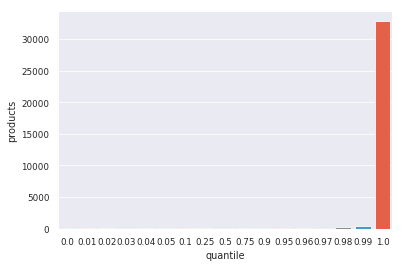

In [9]:
axp = sns.barplot(x="quantile", y="products", data=product_q, palette=five_thirty_eight)

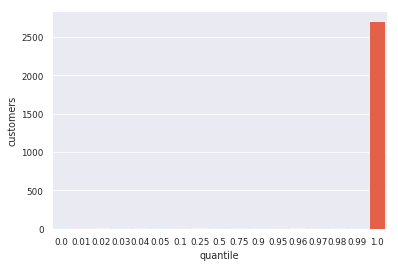

In [10]:
axc = sns.barplot(x="quantile", y="customers", data=customer_q, palette=five_thirty_eight)

As we can see, only about 5% of customers have rated 5 or more videos, and only 25% of videos have been rated by 9+ customers.

### Clean

Let's filter out this long tail and remove any duplicate reviews (same product and customer).

In [11]:
customers = customers[customers >= 5]
products = products[products >= 10]

print("# of records before removing the long tail = {:10d}".format(reviews.shape[0]))
reduced_df = reviews.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))
print("# of records after  removing the long tail = {:10d}".format(reduced_df.shape[0]))
reduced_df = reduced_df.drop_duplicates(['customer_id', 'product_id'])
print("# of records after  removing duplicates    = {:10d}".format(reduced_df.shape[0]))

# of records before removing the long tail =    3998345
# of records after  removing the long tail =    1168955
# of records after  removing duplicates    =    1168903


Now, we'll recreate our customer and product lists since there are customers with more than 5 reviews, but all of their reviews are on products with less than 5 reviews (and vice versa).

In [12]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

Next, we'll number each user and item, giving them their own sequential index.  This will allow us to hold the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.

In [13]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'customer': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'product': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,star_rating,product_title,customer,product
0,27072354,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,10974,107
1,16030865,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,481,107
2,44025160,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,31093,107
3,18602179,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,2096,107
4,14424972,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,34200,107


Let's look at the feature dimension size whch will required for preparing the training and test data sets

In [14]:
nb_customer = reduced_df['customer'].max() + 1
nb_products = reduced_df['product'].max() + 1
feature_dim = nb_customer + nb_products
print(nb_customer, nb_products, feature_dim)

(140344, 38385, 178729)


Trim down the data set to include only customer, product, star_rating which is all we need for the training algorithm to build the model

In [15]:
product_df = reduced_df[['customer', 'product', 'star_rating']]
product_df.head()

,customer,product,star_rating
0,10974,107,5
1,481,107,5
2,31093,107,5
3,2096,107,5
4,34200,107,5


### Prepare

We will be using SageMaker's implementation of Factorization Machines (FM) for building a recommender system. The algorithm expects float32 tensors in protobuf whereas the data sets are pandas dataframe on disk. Most of the conversion effort is handled by the Amazon SageMaker Python SDK.

The FM algorithm will utilize sparse input and since the data sets are dense matrix, it has to be converted a sparse matrix with one-hot encoded feature vectors with customers and products. Thus, each sample in the data set will be a wide boolean vector with 178729 feature space (140344 customer + 38385 products) with only two values set to 1 with respect to the customer and product.

Following are the next steps

1. Split the cleaned data set into train and test data sets.
2. For each set, build a sparse matrix with one-hot encoded feature vectors (customer + products) and a label vector with star ratings.
3. Convert both the sets to protobuf encoded files.
4. Copy these files to an Amazon S3 bucket.
5. Configure and run a Factorization Machines training job on Amazon SageMaker.
6. Deploy the corresponding model to an endpoint.
7. Run predictions on test data set and validate

#### Split into Training and Test Data Sets

Let's start by [splitting](https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html) in training, validation and test sets.  This will allow us to estimate the model's accuracy on videos our customers rated, but wasn't included in our training. We will use validation data set specifically for tuning model hyper-parameters.

In [16]:
train_df, validate_df, test_df = np.split(
    product_df.sample(frac=1), 
    [int(.6*len(product_df)), int(.8*len(product_df))])

In [17]:
print("# of rows in the training data set   = {:10d}".format(train_df.shape[0]))
print("# of rows in the validation data set = {:10d}".format(validate_df.shape[0]))
print("# of rows in the test data set       = {:10d}".format(test_df.shape[0]))

# of rows in the training data set   =     701341
# of rows in the validation data set =     233781
# of rows in the test data set       =     233781


In [18]:
train_df.head()

,customer,product,star_rating
1160169,76977,32390,5
482349,65653,473,5
661067,52655,1677,5
916814,14074,6523,5
302666,92543,1814,4


Let's get the feature dimensions by adding total number of (unique) customers and products

In [19]:
# get feature dimension
all_df = pd.concat([train_df, validate_df, test_df])
nb_customer = np.unique(all_df['customer'].values).shape[0]
nb_products = np.unique(all_df['product'].values).shape[0]
feature_dim = nb_customer + nb_products
print("# of customers = {:10d}".format(nb_customer))
print("# of products  = {:10d}".format(nb_products))
print("# of features  = {:10d}".format(feature_dim))

# of customers =     140344
# of products  =      38385
# of features  =     178729


#### Building Sparse One-Hot Encoded Matrix

Our training matrix is now even sparser: Of all 183,833,321,511 values (1028559 rows * 178729 columns), only 2,057,118 are non-zero (1,028,559*2). In other words, the matrix is 99.99% sparse. Storing this as a dense matrix would be a massive waste of both storage and computing power. To avoid this, use a scipy.lil_matrix sparse matrix for features and a numpy array for ratings.

Let's define a function that takes the data set and returns a sparse feature matrix and numpy array with ratings.

In [20]:
def convert_sparse_matrix(df, nb_rows, nb_customer, nb_products):
    # dataframe to array
    df_val = df.values

    # determine feature size
    nb_cols = nb_customer + nb_products
    print("# of rows = {}".format(str(nb_rows)))
    print("# of cols = {}".format(str(nb_cols)))

    # extract customers and ratings
    df_X = df_val[:, 0:2]
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((nb_rows, nb_cols)).astype('float32')
    df_X[:, 1] = nb_customer + df_X[:, 1]
    coords = df_X[:, 0:2]
    X[np.arange(nb_rows), coords[:, 0]] = 1
    X[np.arange(nb_rows), coords[:, 1]] = 1

    # create label with ratings
    Y = df_val[:, 2].astype('float32')

    # validate size and shape
    print(X.shape)
    print(Y.shape)
    assert X.shape == (nb_rows, nb_cols)
    assert Y.shape == (nb_rows, )

    return X, Y

In [21]:
print("Convert training data set to one-hot encoded sparse matrix")
train_X, train_Y = convert_sparse_matrix(train_df, train_df.shape[0], nb_customer, nb_products)
print("Convert validation data set to one-hot encoded sparse matrix")
validate_X, validate_Y = convert_sparse_matrix(validate_df, validate_df.shape[0], nb_customer, nb_products)
print("Convert test data set to one-hot encoded sparse matrix")
test_X, test_Y = convert_sparse_matrix(test_df, test_df.shape[0], nb_customer, nb_products)

Convert training data set to one-hot encoded sparse matrix
# of rows = 701341
# of cols = 178729
(701341, 178729)
(701341,)
Convert validation data set to one-hot encoded sparse matrix
# of rows = 233781
# of cols = 178729
(233781, 178729)
(233781,)
Convert test data set to one-hot encoded sparse matrix
# of rows = 233781
# of cols = 178729
(233781, 178729)
(233781,)


#### Convert to Protobuf format and Upload to S3

We will use Sagemaker's utility function [`write_spmatrix_to_sparse_tensor`](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/amazon/common.py) to convert scipy sparse matrix to protobuf format.

In [22]:
def save_as_protobuf(X, Y, bucket, key):
    """Converts features and predictions matrices to recordio protobuf and
       writes to S3

    Args:
        X:
          2D numpy matrix with features
        Y:
          1D numpy matrix with predictions
        bucket:
          s3 bucket where recordio protobuf file will be staged
        prefix:
          s3 url prefix to stage prepared data to use for training the model
        key:
          protobuf file name to be staged

    Returns:
        s3 url with key to the protobuf data
    """
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}'.format(key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket, obj)

In [23]:
s3_train_path = save_as_protobuf(train_X, train_Y, bucket, 'prepare/train/train.protobuf')
print("Training data set in protobuf format uploaded at {}".format(s3_train_path))
s3_val_path = save_as_protobuf(validate_X, validate_Y, bucket, 'prepare/validate/validate.protobuf')
print("Validation data set in protobuf format uploaded at {}".format(s3_val_path))

Training data set in protobuf format uploaded at s3://sagemaker-us-east-1-835319576252/prepare/train/train.protobuf
Validation data set in protobuf format uploaded at s3://sagemaker-us-east-1-835319576252/prepare/validate/validate.protobuf


We will chunk the test data to avoid the payload size issues when performing batch predictions.

In [24]:
def chunk(x, batch_size):
    """split array into chunks of batch_size
    """
    chunk_range = range(0, x.shape[0], batch_size)
    chunks = [x[p: p + batch_size] for p in chunk_range]
    return chunks

In [25]:
test_x_chunks = chunk(test_X, 10000)
test_y_chunks = chunk(test_Y, 10000)
N = len(test_x_chunks)
for i in range(N):
    test_data = save_as_protobuf(
        test_x_chunks[i],
        test_y_chunks[i],
        bucket,
        "prepare/test/test_" + str(i) + ".protobuf")
    print(test_data)

s3://sagemaker-us-east-1-835319576252/prepare/test/test_0.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_1.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_2.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_3.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_4.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_5.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_6.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_7.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_8.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_9.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_10.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_11.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_12.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_13.protobuf
s3://sagemaker-us-east-1-835319576252/prepare/test/test_14

---

## Model Training

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. We'll use the Amazon SageMaker Python SDK to kick off training and monitor status until it is completed. In this example that takes between 4-7 minutes for 3-10 epochs. 

First, let's get the Sagemaker Factorization Machine container

In [26]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'factorization-machines')

Next kick off the base estimator, making sure to pass in the necessary hyperparameters. Notice:

- `feature_dim` is set to 178729, which is the number of customers + products in the training data set.
- `predictor_type` is set to 'regressor' since we are trying to predict the rating
- `mini_batch_size` is set to 200. This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.
- `num_factors` is set to 64. Factorization machines find a lower dimensional representation of the interactions for all features. Making this value smaller provides a more parsimonious model, closer to a linear model, but may sacrifice information about interactions. Making it larger provides a higher-dimensional representation of feature interactions, but adds computational complexity and can lead to overfitting. In a practical application, time should be invested to tune this parameter to the appropriate value.

In [27]:
%time

output_location = 's3://{}/train/'.format(bucket)
s3_train_path = 's3://{}/prepare/train/train.protobuf'.format(bucket)
s3_val_path = 's3://{}/prepare/validate/validate.protobuf'.format(bucket)

fm = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c5.4xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)

fm.set_hyperparameters(feature_dim=feature_dim,
                      predictor_type='regressor',
                      mini_batch_size=200,
                      num_factors=512,
                      bias_lr=0.02,
                      epochs=10)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [28]:
fm.fit({'train': s3_train_path,'test': s3_val_path}, wait=False)

Amazon SageMaker built-in algorithms automatically compute and emit a variety of model training, evaluation, and validation metrics that can be captured from Cloudwatch using Sagemaker SDK. Since we are using FM built-in algorithm with predictor type as `regressor`, we can capture RMSE (root-mean-square error) of the model that measures the differences between the predicted values and the actual values.

Let's capture the RMSE of the model

In [29]:
training_job_name = fm._current_job_name
metric_name = 'train:rmse:epoch'

In [40]:
# run this cell to check current status of training job
fm_training_job_result = sm.describe_training_job(TrainingJobName=training_job_name)
print(fm_training_job_result)

status = fm_training_job_result['TrainingJobStatus']
if status != 'Completed':
    print('Reminder: the training job has not been completed.')
else:
    print('The training job is completed')

{u'TrainingJobName': u'factorization-machines-2020-10-27-00-41-14-792', 'ResponseMetadata': {'RetryAttempts': 0, 'HTTPStatusCode': 200, 'RequestId': 'ba874c9a-4ebd-415d-8538-b3819757aaac', 'HTTPHeaders': {'x-amzn-requestid': 'ba874c9a-4ebd-415d-8538-b3819757aaac', 'date': 'Tue, 27 Oct 2020 00:43:15 GMT', 'content-length': '4962', 'content-type': 'application/x-amz-json-1.1'}}, u'TrainingJobArn': u'arn:aws:sagemaker:us-east-1:835319576252:training-job/factorization-machines-2020-10-27-00-41-14-792', u'InputDataConfig': [{u'CompressionType': u'None', u'ChannelName': u'test', u'DataSource': {u'S3DataSource': {u'S3DataType': u'S3Prefix', u'S3DataDistributionType': u'FullyReplicated', u'S3Uri': u's3://sagemaker-us-east-1-835319576252/prepare/validate/validate.protobuf'}}, u'RecordWrapperType': u'None'}, {u'CompressionType': u'None', u'ChannelName': u'train', u'DataSource': {u'S3DataSource': {u'S3DataType': u'S3Prefix', u'S3DataDistributionType': u'FullyReplicated', u'S3Uri': u's3://sagemake

In [41]:
%%time

fm.latest_training_job.wait(logs=False)


2020-10-27 00:44:04 Starting - Preparing the instances for training
2020-10-27 00:44:04 Downloading - Downloading input data
2020-10-27 00:44:04 Training - Training image download completed. Training in progress.....................................
2020-10-27 00:48:01 Uploading - Uploading generated training model........
2020-10-27 00:48:48 Completed - Training job completed


# Wait for the job ^^ above ^^ to complete

In [42]:
# plug-in the training job name and metrics to be captured
metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,
                                         metric_names=[metric_name]).dataframe()
metrics_dataframe

,metric_name,timestamp,value
0,train:rmse:epoch,0.0,1.185032
1,train:rmse:epoch,60.0,0.998977
2,train:rmse:epoch,120.0,0.866597


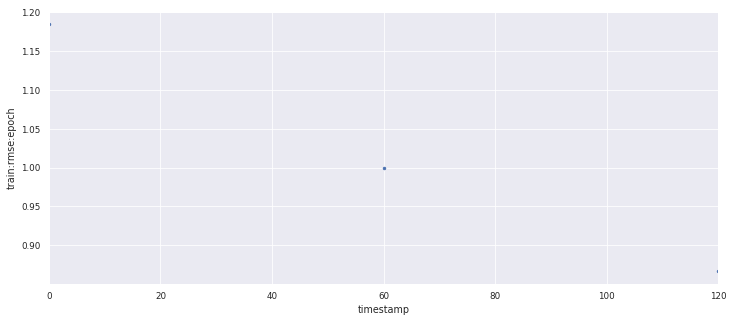

In [43]:
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

As the number of epochs increased, RMSE goes down which is a good sign that the predicted values are getting closer to the actual values from the test set. We can increase number of epochs or change the hyperparameters and try to tweak the model. Let's try to deploy this model and make predictions to see how close the predictions are. Then we can run a hyper-parameter tuning job to determine the best model.

#### Utility Functions

We will define some common utility functions here that will be used during inference and evaluating results

In [44]:
def convert_to_protobuf(X, Y=None):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    return buf

In [45]:
def convert_sparse_matrix_X(df, nb_rows, nb_customer, nb_products):
    # dataframe to array
    df_val = df.values

    # determine feature size
    nb_cols = nb_customer + nb_products
    
    # extract customers and ratings
    df_X = df_val[:,0:2]
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((nb_rows, nb_cols)).astype('float32')
    df_X[:,1] = nb_customer + df_X[:,1]
    coords = df_X[:,0:2]
    X[np.arange(nb_rows), coords[:, 0]] = 1
    X[np.arange(nb_rows), coords[:, 1]] = 1

    # validate size and shape
    assert X.shape == (nb_rows, nb_cols)
    
    return X

---

## Inference 

### Real-Time Inference 

Since the model is trained, all it takes to deploy the model is a Sagemaker API call `deploy()` that creates the model package, sets up endpoint configuration and finally creates the endpoint.

In [46]:
%%time

fm_predictor = fm.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1)

-----------------!

Predictions could be done by sending HTTP POST requests from a separate web service, but to keep things easy, we'll just use the `.predict()` method from the SageMaker Python SDK. The API expects JSON or RecordIO format for  request and JSON for response data.

In [47]:
fm_predictor.content_type = 'application/x-recordio-protobuf'

Let's test the model with sample ratings from test data set using `predict()` API call

In [48]:
test_pb = convert_to_protobuf(test_X[1000:1010]).getvalue()

In [49]:
response = fm_predictor.predict(test_pb)
response

'{"predictions": [{"score": 3.8316574096679688}, {"score": 3.7261946201324463}, {"score": 3.6552248001098633}, {"score": 4.027756214141846}, {"score": 3.8856489658355713}, {"score": 3.7821013927459717}, {"score": 3.425412178039551}, {"score": 4.217108249664307}, {"score": 3.693544387817383}, {"score": 4.35484504699707}]}'

In [50]:
predicted = [round(r['score'], 2) for r in json.loads(response)['predictions']]
predicted

[3.83, 3.73, 3.66, 4.03, 3.89, 3.78, 3.43, 4.22, 3.69, 4.35]

In [51]:
results_df = pd.DataFrame(zip(test_Y[1000:1010], predicted), columns = ["actual_rating", "predicted_rating"])
results_df

,actual_rating,predicted_rating
0,5.0,3.83
1,5.0,3.73
2,2.0,3.66
3,5.0,4.03
4,4.0,3.89
5,4.0,3.78
6,3.0,3.43
7,5.0,4.22
8,1.0,3.69
9,5.0,4.35


---

### Batch Inference

Here we will perform batch inference on the test data set prepared earlier (chunking into multiple protobuf files). To run batch transform, create a model package for the transform endpoint 

- Create the model from the training estimator

In [52]:
fm_model = fm.create_model()

- Perform batch inference on the test data set and save results to S3

In [53]:
fm_transformer = fm_model.transformer(
    instance_type='ml.c4.xlarge', 
    instance_count=1, 
    strategy="MultiRecord", 
    output_path="s3://{}/transform/".format(bucket)
)

In [54]:
fm_transformer.transform(
    data="s3://{}/prepare/test/".format(bucket), 
    data_type='S3Prefix', 
    content_type="application/x-recordio-protobuf")

In [55]:
%%time

print('Waiting for transform job: ' + fm_transformer.latest_transform_job.job_name)
fm_transformer.wait()

Waiting for transform job: factorization-machines-2020-10-27-00-59-2020-10-27-00-59-00-681
................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[10/27/2020 01:04:05 INFO 140106874853184] loaded entry point class algorithm.serve.server_config:config_api
[10/27/2020 01:04:05 INFO 140106874853184] loading entry points
/opt/amazon/lib/python2.7/site-packages/ai_algorithms_sdk/serve.py:195: DeprecationWarning: entrypoint algorithm.request_iterators is deprecated in favor of algorithm.io.data_handlers.serve
  "in favor of algorithm.io.data_handlers.serve", DeprecationWarning)
[10/27/2020 01:04:05 INFO 140106874853184] loaded request iterator application/x-recordio-protobuf
[10/27/2020 01:04:05 INFO 14

- Inference results will be stored in a separate file for each test file chunk. Let's download the results from S3 and merge them

In [56]:
def download_from_s3(bucket, key):
    s3 = boto3.resource('s3')
    obj = s3.Object( bucket, key)
    content = obj.get()['Body'].read()
    return content

In [57]:
test_preds = []
for i in range(N):
    key = 'transform/test_' + str(i) + '.protobuf.out'
    response = download_from_s3(bucket, key)
    result = [json.loads(row)["score"] for row in response.split("\n") if len(row) > 0]
    test_preds.extend(result)

In [58]:
test_preds = np.array(test_preds)

In [59]:
test_preds.shape

(233781,)

---

## Evaluate Model Performance

Let's start by calculating a naive baseline to approximate how well our model is doing.  The simplest estimate would be to assume every user item rating is just the average rating over all ratings.

*Note, we could do better by using each individual video's average, however, in this case it doesn't really matter as the same conclusions would hold.*

In [60]:
print('Naive MSE:', np.mean((test_df['star_rating'] - np.mean(train_df['star_rating'])) ** 2))

('Naive MSE:', 1.447061540076283)


Now, we'll calculate predictions for our test dataset.

In [61]:
print('MSE:', np.mean((test_Y - test_preds) ** 2))

('MSE:', 1.1478783285179637)


We can see that our neural network and embedding model produces substantially better results (~1.44 vs 1.13 on the mean square error).

For recommender systems, subjective accuracy also matters.  Let's get some recommendations for a random user to see if they make intuitive sense.

In [62]:
df_customer_6 = reduced_df[reduced_df['customer'] == 6].sort_values(['star_rating', 'product'], ascending=[False, True])
pd.concat((df_customer_6.head(10), df_customer_6.tail(10)))

,customer_id,product_id,star_rating,product_title,customer,product
55325,50818682,B00DAHSY58,5,"Under The Dome, Season 1",6,5
96037,50818682,B00LI0VA4Q,5,"Extant, Season 1",6,6
39812,50818682,B00L86ZKAK,5,"Under The Dome, Season 2",6,21
182878,50818682,B006IX92XO,5,Rome Season 1,6,27
83326,50818682,B00821OX98,5,Falling Skies Season 1,6,40
160154,50818682,B008BQG3RE,5,Falling Skies Season 2,6,80
227942,50818682,B00I8H6MGS,5,Dallas Buyers Club,6,98
569635,50818682,B00F35B8F8,5,Star Trek Into Darkness (Plus Bonus Features),6,216
474425,50818682,B004HWYTP4,5,Red,6,226
161472,50818682,B0077RUCRK,5,Carnivale: Season 2,6,286


As we can see, user #6 seems to like sprawling dramamtic television series and sci-fi, but they dislike silly comedies.

Now we'll loop through and predict user #6's ratings for every common video in the catalog, to see which ones we'd recommend and which ones we wouldn't.

In [63]:
def create_payload(cust_id, nb_customer, nb_products, product_index):
    # prepare payload for user #6
    c = [cust_id] * nb_products
    p = product_index['product'].values
    x = pd.DataFrame(zip(c,p))
    p_x = convert_sparse_matrix_X(x, x.shape[0], nb_customer, nb_products)
    x_pb = convert_to_protobuf(p_x)
    return x_pb

In [64]:
x_pb = create_payload(6, nb_customer, nb_products, product_index)

In [65]:
# make predictions using end-point created in Real-Time Inference
response = fm_predictor.predict(x_pb)
predictions = [round(r['score'], 2) for r in json.loads(response)['predictions']]

In [66]:
predictions_df = pd.DataFrame({'product': product_index['product'],
                            'prediction': predictions})

In [67]:
df_results_cust_6 = df_customer_6.merge(predictions_df, on=['product'])[['customer', 'customer_id', 'product', 'product_id', 'product_title', 'star_rating', 'prediction']]
df_results_cust_6.sort_values(['prediction', 'product'], ascending=[False, True])

,customer,customer_id,product,product_id,product_title,star_rating,prediction
4,6,50818682,40,B00821OX98,Falling Skies Season 1,5,5.49
7,6,50818682,216,B00F35B8F8,Star Trek Into Darkness (Plus Bonus Features),5,5.28
43,6,50818682,1710,B009CP81EQ,Bones Season 8,5,5.25
26,6,50818682,911,B002BI6SMI,Taken,5,5.22
0,6,50818682,5,B00DAHSY58,"Under The Dome, Season 1",5,5.13
8,6,50818682,226,B004HWYTP4,Red,5,5.12
23,6,50818682,716,B00F406S2U,Arrow: The Complete Second Season,5,5.11
38,6,50818682,1499,B00F49F96C,Almost Human: The Complete First Season,5,5.11
27,6,50818682,978,B00NEFWXNK,Arrow: Season 3,5,5.09
52,6,50818682,2285,B001LLGA7E,Heroes Volume 1,5,5.07


Indeed, our predicted highly rated shows have some well-reviewed TV dramas and some sci-fi.  Meanwhile, our bottom rated shows include goofball comedies.

*Note, because of random initialization in the weights, results on subsequent runs may differ slightly.*

Let's confirm that we no longer have almost perfect correlation in recommendations with user #7.

In [68]:
x_pb = create_payload(7, nb_customer, nb_products, product_index)
response = fm_predictor.predict(x_pb)
predictions_user7 = [round(r['score'], 2) for r in json.loads(response)['predictions']]

In [69]:
plt.scatter(predictions_df['prediction'], np.array(predictions_user7))
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'show'

---

## Model Tuning

So far, we have developed a deep learning model to predict customer ratings but the model could be improved further by various techniques. In this section, let's see if tuning the hyper-parameters of Factorization Machine is going to make the model any better.

In [71]:
output_location = 's3://{}/train/'.format(bucket)
s3_train_path = 's3://{}/prepare/train/train.protobuf'.format(bucket)
s3_val_path = 's3://{}/prepare/validate/validate.protobuf'.format(bucket)

- Let's create the estimator with Factorization Machines container similar to how we defined in training the model. Also, set the initial hyper-parameters that we know worked before.

In [72]:
fm_estimator = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c5.4xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)

In [73]:
fm_estimator.set_hyperparameters(
    feature_dim=feature_dim,
    predictor_type='regressor',
    mini_batch_size=200,
    num_factors=512,
    bias_lr=0.02,
    epochs=20)

- Find best hyperparameters with Sagemaker's Automatic Model Tuning. Following hyperparameters will be tuned
    - ***factors_lr:*** The learning rate for factorization terms.
    - ***factors_init_sigma:*** The standard deviation for initialization of factorization terms. Takes effect if factors_init_method is set to normal.
    

- Define the hyperparameter tuning ranges to be searched and set the objective metric

In [74]:
hyperparameter_ranges=  {
    "factors_lr": ContinuousParameter(0.0001, 0.2),
    "factors_init_sigma": ContinuousParameter(0.0001, 1)
}

- Now that we have our ranges defined we want to define our success metric

In [75]:
objective_metric_name = "test:rmse"
objective_type = "Minimize"

- Start hyperparameter tuning job with the ranges defined

In [76]:
fm_tuner = HyperparameterTuner(
    estimator=fm_estimator,
    objective_metric_name=objective_metric_name, 
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type=objective_type,
    max_jobs=10,
    max_parallel_jobs=2
)

In [77]:
timestamp_prefix = time.strftime("%Y%m%d-%H%M%S", time.gmtime())
fm_tuner_job_name = 'hpo-fm-' + timestamp_prefix

In [78]:
fm_tuner.fit({'train': s3_train_path, 'test': s3_val_path}, job_name=fm_tuner_job_name, wait=False)

- Track hyperparameter tuning job progress

In [79]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=fm_tuner_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

Reminder: the tuning job has not been completed.
0 training jobs have completed


In [88]:
%%time

fm_tuner.wait()

!
CPU times: user 9.42 ms, sys: 7.72 ms, total: 17.1 ms
Wall time: 1.13 s


* Analyze Hyper-Parameter Tuning Job Results

In [89]:
# plug-in the training job name and metrics to be captured
fm_tuner_analytics = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=fm_tuner_job_name)
df_fm_tuner_metrics = fm_tuner_analytics.dataframe()
df_fm_tuner_metrics

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,factors_init_sigma,factors_lr
0,1.096982,498.0,2020-10-27 05:50:34+00:00,hpo-fm-20201027-045403-010-fdf6d9fa,Completed,2020-10-27 05:42:16+00:00,0.098703,0.000103
1,1.363452,492.0,2020-10-27 05:49:40+00:00,hpo-fm-20201027-045403-009-8f38cd6f,Completed,2020-10-27 05:41:28+00:00,0.192474,0.000107
2,1.103914,473.0,2020-10-27 05:39:05+00:00,hpo-fm-20201027-045403-008-0c0dcf5d,Completed,2020-10-27 05:31:12+00:00,0.001125,0.000147
3,1.073588,499.0,2020-10-27 05:39:18+00:00,hpo-fm-20201027-045403-007-4f34d0fd,Completed,2020-10-27 05:30:59+00:00,0.000137,0.000110
4,1.132511,463.0,2020-10-27 05:29:07+00:00,hpo-fm-20201027-045403-006-a39a4ecf,Completed,2020-10-27 05:21:24+00:00,0.000177,0.000235
5,1.159438,467.0,2020-10-27 05:28:36+00:00,hpo-fm-20201027-045403-005-38c8de1e,Completed,2020-10-27 05:20:49+00:00,0.000100,0.000387
6,1.076811,462.0,2020-10-27 05:16:51+00:00,hpo-fm-20201027-045403-004-8da1715c,Completed,2020-10-27 05:09:09+00:00,0.021933,0.000135
7,1.061027,511.0,2020-10-27 05:16:59+00:00,hpo-fm-20201027-045403-003-ba3bbbca,Completed,2020-10-27 05:08:28+00:00,0.016572,0.000100
8,1.326390,493.0,2020-10-27 05:04:46+00:00,hpo-fm-20201027-045403-002-2b0ccbe3,Completed,2020-10-27 04:56:33+00:00,0.030746,0.000490
9,12.109571,490.0,2020-10-27 05:04:36+00:00,hpo-fm-20201027-045403-001-d6d6d635,Completed,2020-10-27 04:56:26+00:00,0.949034,0.044512


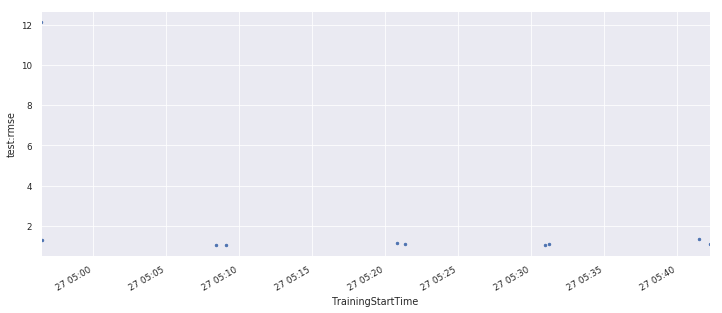

In [90]:
# analyze using seaborn
plt = df_fm_tuner_metrics.plot(kind='line', figsize=(12,5), x='TrainingStartTime', 
                             y='FinalObjectiveValue', 
                             style='b.', legend=False)
plt.set_ylabel(objective_metric_name);

- Best Factorization Machine Model after Hyper-Parameter Optimization

In [92]:
print("fm_tuner_job_name: " + fm_tuner_job_name)
fm_tuner = HyperparameterTuner.attach(fm_tuner_job_name)

fm_tuner_analytics = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=fm_tuner_job_name)
df_fm_tuner_metrics = fm_tuner_analytics.dataframe()

fm_best_model_name = fm_tuner.best_training_job()
print("fm_best_model_name: " + fm_best_model_name)

fm_model_info = sm.describe_training_job(TrainingJobName=fm_best_model_name)

fm_tuner_job_name: hpo-fm-20201027-045403
fm_best_model_name: hpo-fm-20201027-045403-003-ba3bbbca


In [93]:
df_fm_tuner_metrics[df_fm_tuner_metrics['TrainingJobName']==fm_best_model_name]

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,factors_init_sigma,factors_lr
7,1.061027,511.0,2020-10-27 05:16:59+00:00,hpo-fm-20201027-045403-003-ba3bbbca,Completed,2020-10-27 05:08:28+00:00,0.016572,0.0001


- Let's evaluate the results with the best training job from hyper-parameter tuning job.

We can deploy the endpoint using hyper-parameter tuning job and test the predictions. 

In [94]:
fm = sagemaker.estimator.Estimator.attach(fm_best_model_name)

2020-10-27 05:16:59 Starting - Preparing the instances for training
2020-10-27 05:16:59 Downloading - Downloading input data
2020-10-27 05:16:59 Training - Training image download completed. Training in progress.
2020-10-27 05:16:59 Uploading - Uploading generated training model
2020-10-27 05:16:59 Completed - Training job completedDocker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[10/27/2020 05:09:19 INFO 139876871620416] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'inf

We can re-run the cells in Batch Inference and Evaluation section to evaluate the performance of the model with tuned hyper-parameters. 

Assuming batch inference is carried out, let's calculate predictions for our test dataset and see if we do better than the training job with default hyper-parameters.

In [95]:
print('MSE:', np.mean((test_Y - test_preds) ** 2))

('MSE:', 1.1478783285179637)


---

## Wrap-up

In this example, we developed a deep learning model to predict customer ratings.  This could serve as the foundation of a recommender system in a variety of use cases.  However, there are many ways in which it could be improved.  For example we did very little with:
- hyperparameter tuning
- controlling for overfitting (early stopping, dropout, etc.)
- testing whether binarizing our target variable would improve results
- including other information sources (video genres, historical ratings, time of review)
- adjusting our threshold for user and item inclusion 

In addition to improving the model, we could improve the engineering by:
- Setting the context and key value store up for distributed training
- Fine tuning our data ingestion (e.g. num_workers on our data iterators) to ensure we're fully utilizing our GPU
- Thinking about how pre-processing would need to change as datasets scale beyond a single machine

Beyond that, recommenders are a very active area of research and techniques from active learning, reinforcement learning, segmentation, ensembling, and more should be investigated to deliver well-rounded recommendations.

### Clean-up (optional)

Let's finish by deleting our endpoint to avoid stray hosting charges.

In [96]:
endpoint_name_contains = ['-fm-', 'factorization-machines-']
for name in endpoint_name_contains:
    endpoints = sm.list_endpoints(NameContains=name, StatusEquals='InService')
    endpoint_names = [r['EndpointName'] for r in endpoints['Endpoints']]
    for endpoint_name in endpoint_names:
        print("Deleting endpoint: " + endpoint_name)
        sm.delete_endpoint(EndpointName=endpoint_name)

---